In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.figure_data import FigureSingleCellData
from jtb_2022_code.figure_constants import *
from jtb_2022_code.utils.figure_common import *

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scipy.sparse as sps

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as patches

from torch.utils.data import DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from supirfactor_dynamical import (
    read,
    TimeDataset,
    TruncRobustScaler
)

from sklearn.model_selection import train_test_split

/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2023-07-11 14:15:08 2 Preprocessing methods selected: Predictor method zscore [limit 10] Response method zscore [limit 10] Pre-TFA expression method robustscaler [limit 20] 


In [3]:
data = ad.read(INFERELATOR_DATA_FILE)
fit_model = read(SUPIRFACTOR_COUNT_MODEL).eval()

model_data = ad.AnnData(data.layers['counts'][data.obs['Gene'] == "WT", :].astype(np.float32))
model_data.obs = data.obs.loc[data.obs['Gene'] == "WT", :].copy()
model_data.obs['program_rapa_time'] = model_data.obs['program_1_time']
model_data.var = data.var.copy()
model_data = model_data[:, fit_model.prior_network_labels[0]].copy()
sc.pp.normalize_per_cell(model_data, counts_per_cell_after=3099)

_, test_idx = train_test_split(
    np.arange(model_data.shape[0]),
    test_size=0.25,
    random_state=1800
)

data_scaler = TruncRobustScaler(with_centering=False)
model_data.X = data_scaler.fit_transform(model_data.X)

In [1]:
def summarize_model_results(model_results, modeling_type='Counts'):
    
    summary_results = model_results[
        (((model_results['Learning_Rate'] == 5e-5) &
        (model_results['Weight_Decay'] == 1e-7)) |
        pd.isna(model_results['Learning_Rate']))
    ].copy()

    summary_results['model'] = pd.NA
    summary_results['Shuffle'] = False

    summary_results.loc[
        summary_results['Model_Type'] == 'inferelator',
        'model'
    ] = 'inferelator'

    summary_results.loc[
        (summary_results['Model_Type'] == 'static_meta') &
        (summary_results['Time_Axis'] == 'rapa') &
        summary_results[modeling_type],
        'model'
    ] = 'static_meta'

    summary_results.loc[
        (summary_results['Output_Layer_Time_Offset'] == 0) &
        (summary_results['Time_Axis'] == 'combined') &
        ~summary_results['Pretrained_Model'] &
        summary_results[modeling_type],
        'model'
    ] = 'rnn'

    summary_results.loc[
        (summary_results['Output_Layer_Time_Offset'] == 10) &
        (summary_results['Time_Axis'] == 'combined') &
        ~summary_results['Pretrained_Model'] &
        summary_results[modeling_type],
        'model'
    ] = 'rnn_predictive'

    summary_results.loc[
        (summary_results['Output_Layer_Time_Offset'] == 10) &
        (summary_results['Time_Axis'] == 'combined') &
        summary_results['Pretrained_Model'] &
        summary_results[modeling_type],
        'model'
    ] = 'rnn_tuned'

    summary_results = summary_results.dropna(subset='model').drop_duplicates(subset=['model', 'Seed'])

    summary_results['model'] = summary_results['model'].astype(pd.CategoricalDtype(['inferelator', 'static_meta', 'rnn', 'rnn_predictive', 'rnn_tuned'], ordered=True))
    summary_results['x_loc'] = summary_results['model'].cat.codes * 4 + summary_results['Shuffle'].astype(int) + 0.5
    summary_results['x_color'] = summary_results['model'].cat.codes.map(lambda x: colors.rgb2hex(matplotlib.colormaps['Dark2'](x)))
    summary_results.loc[summary_results['Shuffle'], 'x_color'] = "#000000"

    model_stats = summary_results.groupby(['x_loc', 'model', 'Shuffle', 'x_color'])['AUPR'].agg(['std', 'mean']).dropna().reset_index()
    
    return summary_results, model_stats

summary_results, model_stats = load_model_results(None)

NameError: name 'pd' is not defined

In [14]:
summary_results['model'].value_counts()

model
inferelator       10
static_meta       10
rnn               10
rnn_predictive    10
rnn_tuned         10
Name: count, dtype: int64

In [7]:
def plot_gene_predicts(
    gene_name,
    expression_data,
    predicted_data,
    mean_data,
    ax=None,
    dropout=None
):

    rgen = np.random.default_rng(441)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)
    else:
        fig = None
    
    _g_idx = expression_data.var_names == gene_name
    _scale = data_scaler.scale_[_g_idx]

    _gene_data = expression_data.X[:, _g_idx]
    _gene_data *= _scale
    
    try:
        _gene_data = _gene_data.A.ravel()
    except AttributeError:
        pass
    
    _gene_data = _gene_data[test_idx]
    _time_data = expression_data.obs['program_rapa_time'].values[test_idx]
    _color_data = to_pool_colors(expression_data.obs['Pool'])[test_idx]

    overplot_shuffle = np.arange(_gene_data.shape[0])
    rgen.shuffle(overplot_shuffle)
    
    ax.scatter(
        _time_data[overplot_shuffle],
        _gene_data[overplot_shuffle],
        alpha=0.01,
        c=_color_data[overplot_shuffle],
        s=1
    )

    ax.set_xlim(-10, 60)
    ax.set_ylim(0, np.quantile(_gene_data, 0.98))
    ax.axvline(0, 0, 1, linestyle=":", linewidth=1, c="black")
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    ax.plot(
        mean_data.index.values,
        mean_data[gene_name].values,
        c="black",
        linewidth=1
    )

    ax.scatter(
        np.tile(np.arange(0, 60) + 0.5, predicted_data.shape[0]),
        predicted_data[:, 10:, _g_idx].ravel() * _scale,
        c="red",
        s=1,
        alpha=0.01
    )

    ax.plot(
        np.arange(0, 60) + 0.5,
        predicted_data[:, 10:, _g_idx].mean(axis=0) * _scale,
        c="black",
        linewidth=1,
        linestyle="--"
    )
   
    return fig


def _time_slice(t, times):
    idx = times > t
    idx &= times <= (t+1)
    
    return idx

In [8]:
data_mean = pd.DataFrame(
    data_scaler.inverse_transform(np.array(
        [np.median(model_data.X[_time_slice(i, model_data.obs['program_rapa_time']), :].A, axis=0) for i in range(-10, 59)]
    )),
    index=range(-10, 59),
    columns=model_data.var_names
)
    
predicts_training = fit_model.predict(
    DataLoader(
        TimeDataset(
            model_data.X,
            model_data.obs['program_rapa_time'],
            -10,
            0,
            1,
            sequence_length=10,
            shuffle_time_vector=[-10, 0]
        ),
        batch_size=500,
        drop_last=False
    ),
    60
).numpy()

In [ ]:
dropout_tensor = torch.stack(
    [dl.mean(axis=0) for dl in DataLoader(
        TimeDataset(
            model_data.X,
            model_data.obs['program_rapa_time'],
            -10,
            0,
            1,
            sequence_length=10,
            shuffle_time_vector=[-10, 0]
        ),
        batch_size=50,
        drop_last=True
    )],
    dim=0
)

def _predict_dropout(seed_sequence, dropout_gene):
    
    fit_model.set_drop_tfs(dropout_gene)
    preds = fit_model.predict(seed_sequence, 60).mean(axis=0).numpy()
    fit_model.set_drop_tfs(None)
    
    return preds

dropout_predicts = {
    x: data_scaler.inverse_transform(
        _predict_dropout(dropout_tensor, x)
    )
    for x in fit_model.prior_network_labels[1]
}

dropout_predicts[None] = data_scaler.inverse_transform(
    _predict_dropout(dropout_tensor, None)
)

In [ ]:
pd.DataFrame(
    np.array([dropout_predicts[k][..., fit_model.prior_network_labels[0] == "YKR039W"].ravel() for k in dropout_predicts.keys()]) / dropout_predicts[None][..., fit_model.prior_network_labels[0] == "YKR039W"].ravel(),
    index = dropout_predicts.keys()
).T.dropna().T.mean(axis=1).sort_values()

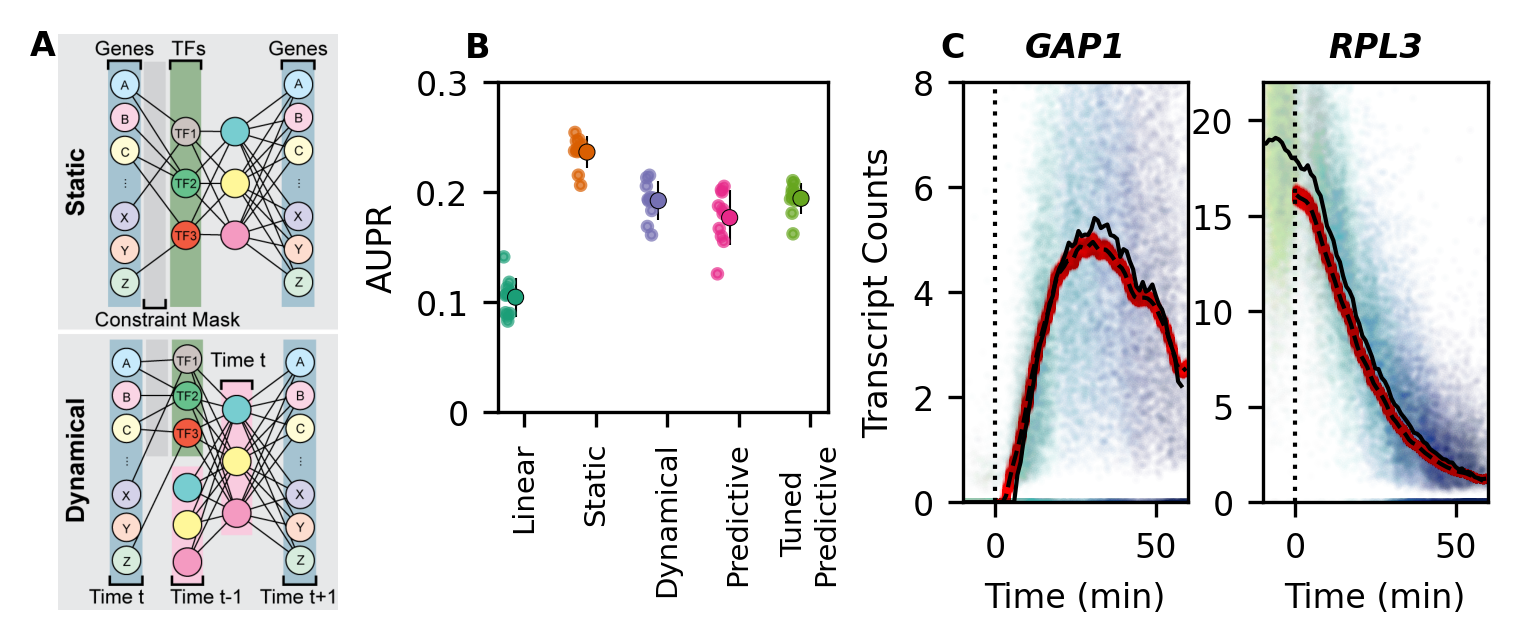

In [52]:
fig_refs = {}
fig = plt.figure(figsize=(5, 2), dpi=MAIN_FIGURE_DPI)

rng = np.random.default_rng(100)

_height = 0.37
_width = 0.25

axd = {
    'schematic': fig.add_axes([0.02, 0.02, 0.2, 0.96]),
    'results': fig.add_axes([0.32, 0.35, 0.22, 0.55]),
    'up_predicts': fig.add_axes([0.63, 0.2, 0.15, 0.7]),
    'down_predicts': fig.add_axes([0.83, 0.2, 0.15, 0.7])
}


axd['schematic'].imshow(plt.imread(str(SchematicFile("Deep_Learning_Model.png"))), aspect='equal')
axd['schematic'].axis('off')
axd['schematic'].set_title("A", loc='left', weight='bold', size=8, x=-0.1, y=0.92)

axd['results'].scatter(
    summary_results['x_loc'] + rng.uniform(-0.2, 0.2, summary_results.shape[0]),
    summary_results['AUPR'],
    color=summary_results['x_color'],
    s=5,
    alpha=0.7
)

axd['results'].scatter(
    model_stats['x_loc'] + 0.5,
    model_stats['mean'],
    color=model_stats['x_color'],
    s=15,
    edgecolor='black',
    linewidth=0.25,
    alpha=1
)

axd['results'].errorbar(
    model_stats['x_loc'] + 0.5,
    model_stats['mean'],
    yerr=model_stats['std'],
    fmt='none',
    color='black',
    alpha=1,
    linewidth=0.5,
    zorder=-1
)

axd['results'].set_ylim(0, 0.3)
axd['results'].set_xlim(0, 18.5)
axd['results'].set_yticks([0, 0.1, 0.2, 0.3], [0, 0.1, 0.2, 0.3], size=8)
axd['results'].set_xticks([1.5, 5.5, 9.5, 13.5, 17.5], ['Linear', 'Static', 'Dynamical', 'Predictive', 'Tuned\nPredictive'], size=7, rotation=90)
axd['results'].set_title("B", loc='left', weight='bold', size=8, x=-.1)
axd['results'].set_ylabel("AUPR", size=8)

plot_gene_predicts(
    "YKR039W",
    model_data,
    predicts_training,
    data_mean,
    ax=axd['up_predicts']
)

axd['up_predicts'].set_title("GAP1", weight='bold', style='italic', size=8)
axd['up_predicts'].set_title("C", loc='left', weight='bold', size=8, x=-0.1)
axd['up_predicts'].set_ylim(0, 8)
axd['up_predicts'].set_ylabel("Transcript Counts", size=8)
axd['up_predicts'].set_xlabel("Time (min)", size=8)

plot_gene_predicts(
    "YOR063W",
    model_data,
    predicts_training,
    data_mean,
    ax=axd['down_predicts']
)

axd['down_predicts'].set_title("RPL3", weight='bold', style='italic', size=8)
axd['down_predicts'].set_ylim(0, 22)
axd['down_predicts'].set_xlabel("Time (min)", size=8)

#ax_lr = fig.add_axes([0, 0, 1, 1], zorder=-3)
#ax_lr.add_patch(patches.Rectangle((0, 0), 1, 1, color='lavender'))
#ax_lr.axis('off')

fig.savefig("figures/Figure_3.png", facecolor="white")